In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun13_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
def track_smear(kinetic_energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))

def test_smear(pz):
    c_eres_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                c_eres = random.gauss(1,0.0404);
            elif element <= 100: 
                c_eres = random.gauss(1,0.0410);
            elif element <= 250: 
                c_eres = random.gauss(1,0.0415);
            elif element <= 500: 
                c_eres = random.gauss(1,0.0420);
            elif element <= 1000: 
                c_eres = random.gauss(1,0.0435);
            elif element <= 2000:  
                c_eres = random.gauss(1,0.0477);
            elif element <= 3000:  
                c_eres = random.gauss(1,0.0523);
            elif element <= 4000:  
                c_eres = random.gauss(1,0.0573);            
            else:    
                c_eres = random.gauss(1,0.06);
            c_eres_array=np.append(c_eres_array, [c_eres])
    return (c_eres_array)

In [5]:
hists = {}
hists["sim_pion_theta1"] = hist.Hist("Sim Kaons",    
                                hist.Bin("theta", r"$\theta [rad]$", 80, 0, 4),
                            ) 
hists["sim_pion_theta2"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("theta", r"$\theta [rad]$", 80, 0, 4),
                            ) 
hists["sim_pion_sume1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Energy [MeV]", 80, 0, 4000), 
                            )
hists["sim_pion_sume2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Energy [MeV]", 80, 0, 4000), 
                            )  
hists["sim_pion_e1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Energy [MeV]", 80, 0, 2500), 
                            )
hists["sim_pion_e2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Energy [MeV]", 80, 0, 2500), 
                            )  

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    sim_kaon = ldmx_events['Sim_Kaon']
    
    sim_kaon_dau1 = ldmx_events['Sim_Kaon_dau1']
    sim_kaon_dau2 = ldmx_events['Sim_Kaon_dau2']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    kaon_mass = 497.648
    
    kshort_mask = (abs(sim_kaon_dau2.mompdgID)==kshort_pdgid)
    pidau_mask = (abs(sim_kaon_dau2.pdgID)==chargedpion_pdgid)

    kaonvector = get_vector(sim_kaon[pidau_mask & kshort_mask])
    pi1 = get_vector(sim_kaon_dau1[pidau_mask & kshort_mask])
    pi2 = get_vector(sim_kaon_dau2[pidau_mask & kshort_mask])
    pisum = (pi1 + pi2)
    pisum_energy_append = np.append(flat(pi1.t), flat(pi2.t))
    
    new_ke1 = track_smear(pi1.t - pion_mass, pi1.theta)[0]
    new_ke2 = track_smear(pi2.t - pion_mass, pi2.theta)[0]
    new_kek = track_smear(kaonvector.t - kaon_mass, kaonvector.theta)[0]
    new_theta1 = track_smear(pi1.t - pion_mass, pi1.theta)[1]
    new_theta2 = track_smear(pi2.t - pion_mass, pi2.theta)[1]
    new_thetak = track_smear(kaonvector.t - kaon_mass, kaonvector.theta)[1]
    
    new_pz1 = test_smear(pi1.pz)*flat(pi1.pz)
    new_psq1 = flat(pi1.px)**2+flat(pi1.py)**2+new_pz1**2
    new_pz2= test_smear(pi2.pz)*flat(pi2.pz)
    new_psq2 = flat(pi2.px)**2+flat(pi2.py)**2+new_pz2**2
    new_pzk= test_smear(kaonvector.pz)*flat(kaonvector.pz)
    new_psqk = flat(kaonvector.px)**2+flat(kaonvector.py)**2+new_pzk**2
    
    kaon_track_smeared =  ak.zip({"x": kaonvector.pz,
                    "y": kaonvector.rho*np.sin(new_thetak)*np.sin(kaonvector.phi),
                    "z": kaonvector.rho*np.cos(new_thetak),
                    "t": new_kek+kaon_mass,
                    },
                    with_name="LorentzVector")
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    pi1_track_smeared =  ak.zip({"x": flat(pi1.px),
                    "y": flat(pi1.py),
                    "z": new_pz1,
                    "t": (np.sqrt(new_psq1+flat(pi1.mass)**2)),
                    },
                    with_name="LorentzVector")
    pi2_track_smeared =  ak.zip({"x": flat(pi2.px),
                    "y": flat(pi2.py),
                    "z": new_pz2,
                    "t": (np.sqrt(new_psq2+flat(pi2.mass)**2)),
                    },
                    with_name="LorentzVector")
    
    
    pisum_track_smeared =(pi1_track_smeared+pi2_track_smeared)
    pismeared_energy_append = np.append(flat(pi1_track_smeared.t),flat(pi2_track_smeared.t))
        
    
    hists["sim_pion_theta1"].fill(
                                 theta=flat(pisum.theta),
                                )
    hists["sim_pion_theta2"].fill(
                                 theta=flat(pisum_track_smeared.theta),
                                ) 
    hists["sim_pion_sume1"].fill(
                                 e=flat(pisum.t),
                                )
    hists["sim_pion_sume2"].fill(
                                 e=flat(pisum_track_smeared.t),
                                ) 
    hists["sim_pion_e1"].fill(
                                 e=flat(pisum_energy_append),
                                )
    hists["sim_pion_e2"].fill(
                                 e=flat(pismeared_energy_append),
                                ) 
    
    return

In [7]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
process 16
process 17
process 18
process 19
process 20
process 21
process 22
process 23
process 24
process 25
process 26
process 27
process 28
process 29
process 30
process 31
process 32
process 33
process 34
process 35
process 36
process 37
process 38
process 39
process 40
process 41
process 42
process 43
process 44
process 45
process 46
process 47
process 48
process 49
process 50
process 51
process 52
process 53
process 54
process 55
process 56
process 57
process 58
process 59
process 60
process 61
process 62
process 63
process 64
process 65
process 66
process 67
process 68
process 69
process 70
process 71


<Hist (theta) instance at 0x12b07c520>


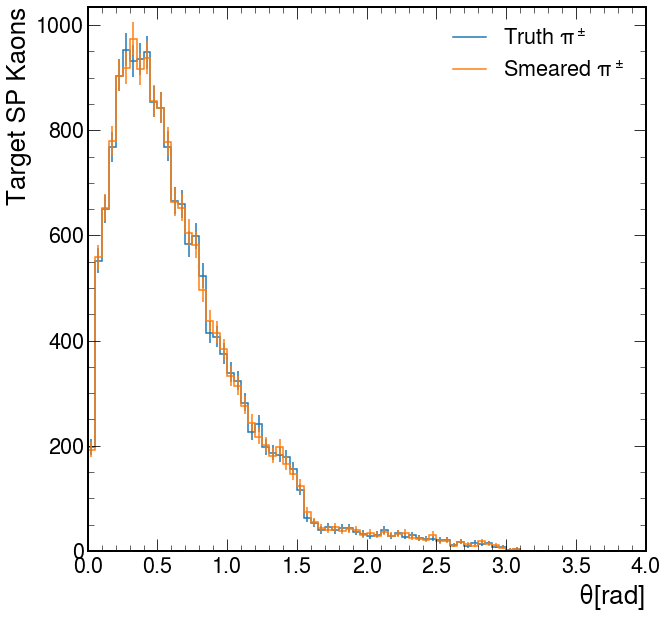

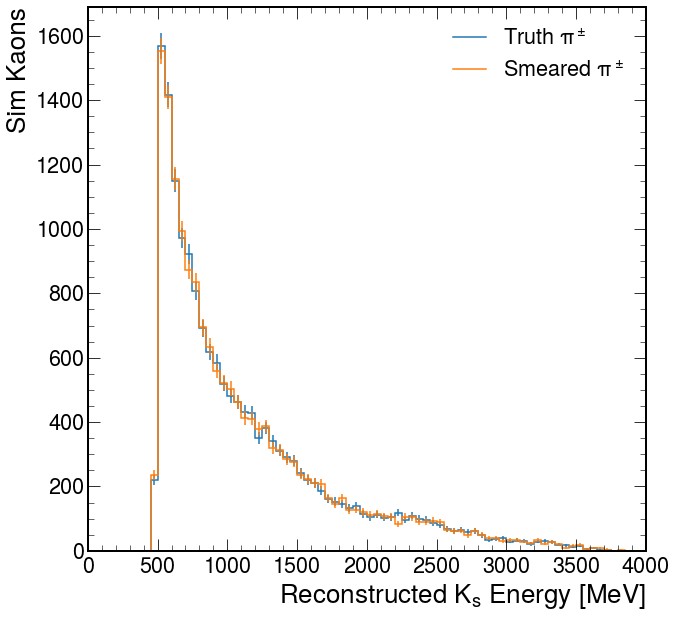

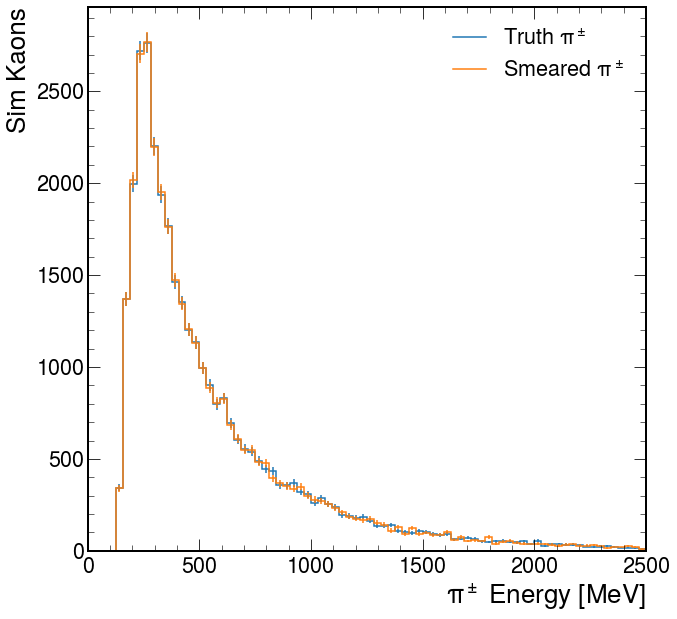

In [8]:
print(hists["sim_pion_theta1"])
fig, ax = plt.subplots()
hist.plot1d(hists["sim_pion_theta1"],ax=ax,clear=False);
hist.plot1d(hists["sim_pion_theta2"],ax=ax,clear=False);
leg = ax.legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])

fig, ax = plt.subplots()
hist.plot1d(hists["sim_pion_sume1"],ax=ax,clear=False);
hist.plot1d(hists["sim_pion_sume2"],ax=ax,clear=False);
leg = ax.legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])

fig, ax = plt.subplots()
hist.plot1d(hists["sim_pion_e1"],ax=ax,clear=False);
hist.plot1d(hists["sim_pion_e2"],ax=ax,clear=False);
leg = ax.legend([r'Truth $\pi^\pm$', 'Smeared $\pi^\pm$'])
